In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter

In [216]:
training_data_file = '../data/training_data/2005-2015_training_data.csv'

In [320]:
data = pd.read_csv(training_data_file)
data['pres.sfc'] = data['pres.sfc'] / 1000
data['abs.vwnd.10m'] = abs(data['vwnd.10m'])
data['abs.uwnd.10m'] = abs(data['uwnd.10m'])
data['ignition'].fillna(0, inplace=True)
ignition = data[data['ignition'] == 1]
no_ignition = data[data['ignition'] == 0]

First let's check the distribution of all of the weather variables over the whole dataset.

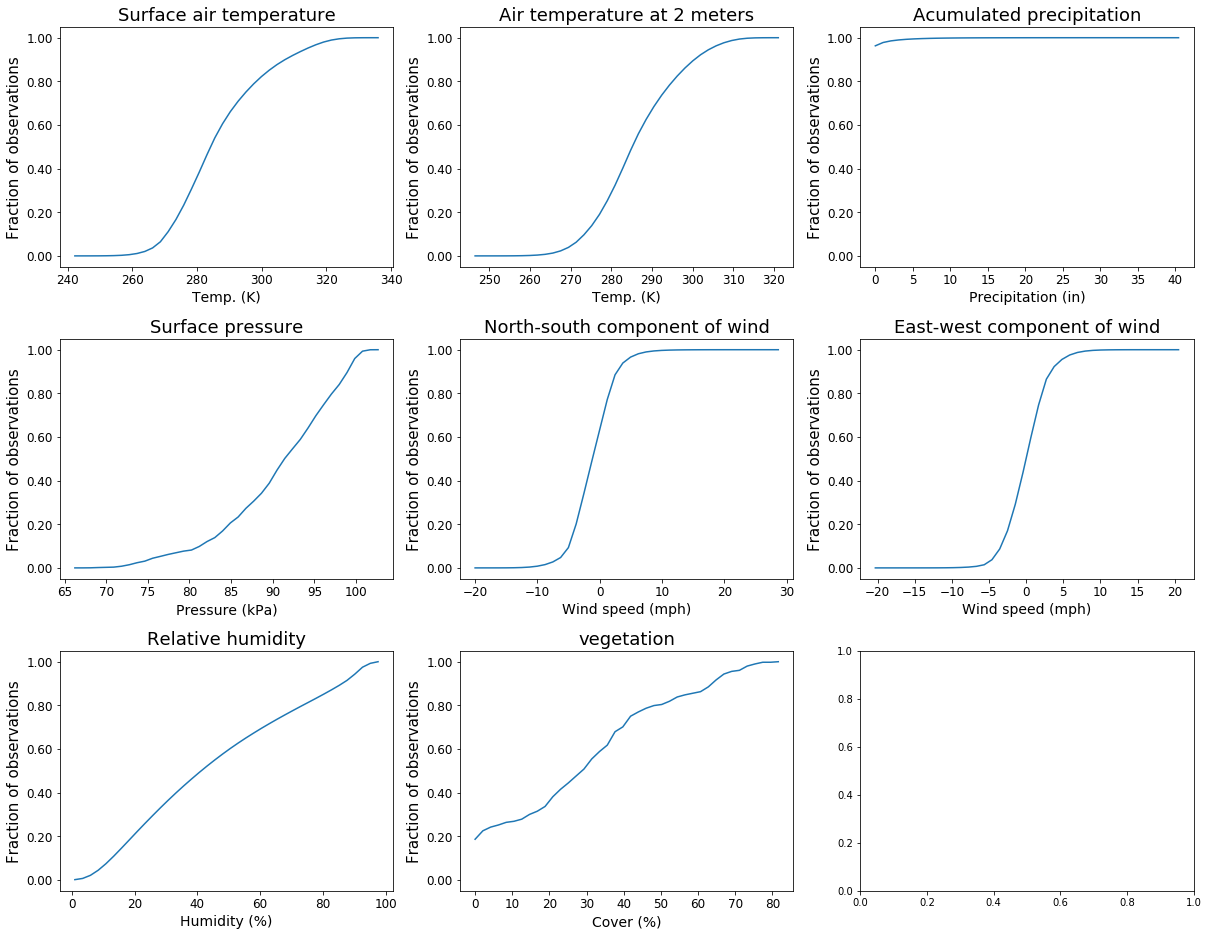

In [325]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.65    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig, ax = plt.subplots(3, 3, figsize=(30, 15))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

values, base = np.histogram(data['air.sfc'], bins=40)
cumulative = np.cumsum(values) / len(data)

ax[0,0].plot(base[:-1], cumulative)
ax[0,0].tick_params(labelsize=12)
ax[0,0].set_title('Surface air temperature', fontsize=18)
ax[0,0].set_xlabel('Temp. (K)', fontsize=14)
ax[0,0].set_ylabel('Fraction of observations', fontsize=15)
ax[0,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[0,0].set_ylim([-0.05,1.05])

values, base = np.histogram(data['air.2m'], bins=40)
cumulative = np.cumsum(values) / len(data)

ax[0,1].plot(base[:-1], cumulative)
ax[0,1].tick_params(labelsize=12)
ax[0,1].set_title('Air temperature at 2 meters', fontsize=18)
ax[0,1].set_xlabel('Temp. (K)', fontsize=14)
ax[0,1].set_ylabel('Fraction of observations', fontsize=15)
ax[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[0,1].set_ylim([-0.05,1.05])

values, base = np.histogram(data['apcp'], bins=40)
cumulative = np.cumsum(values) / len(data)

ax[0,2].plot(base[:-1], cumulative)
ax[0,2].tick_params(labelsize=12)
ax[0,2].set_title('Acumulated precipitation', fontsize=18)
ax[0,2].set_xlabel('Precipitation (in)', fontsize=14)
ax[0,2].set_ylabel('Fraction of observations', fontsize=15)
ax[0,2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[0,2].set_ylim([-0.05,1.05])

values, base = np.histogram(data['pres.sfc'], bins=40)
cumulative = np.cumsum(values) / len(data)

ax[1,0].plot(base[:-1], cumulative)
ax[1,0].tick_params(labelsize=12)
ax[1,0].set_title('Surface pressure', fontsize=18)
ax[1,0].set_xlabel('Pressure (kPa)', fontsize=14)
ax[1,0].set_ylabel('Fraction of observations', fontsize=15)
ax[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1,0].set_ylim([-0.05,1.05])

values, base = np.histogram(data['vwnd.10m'], bins=40)
cumulative = np.cumsum(values) / len(data)

ax[1,1].plot(base[:-1], cumulative)
ax[1,1].tick_params(labelsize=12)
ax[1,1].set_title('North-south component of wind', fontsize=18)
ax[1,1].set_xlabel('Wind speed (mph)', fontsize=14)
ax[1,1].set_ylabel('Fraction of observations', fontsize=15)
ax[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1,1].set_ylim([-0.05,1.05])

values, base = np.histogram(data['uwnd.10m'], bins=40)
cumulative = np.cumsum(values) / len(data)

ax[1,2].plot(base[:-1], cumulative)
ax[1,2].tick_params(labelsize=12)
ax[1,2].set_title('East-west component of wind', fontsize=18)
ax[1,2].set_xlabel('Wind speed (mph)', fontsize=14)
ax[1,2].set_ylabel('Fraction of observations', fontsize=15)
ax[1,2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1,2].set_ylim([-0.05,1.05])

values, base = np.histogram(data['rhum.2m'], bins=40)
cumulative = np.cumsum(values) / len(data)

ax[2,0].plot(base[:-1], cumulative)
ax[2,0].tick_params(labelsize=12)
ax[2,0].set_title('Relative humidity', fontsize=18)
ax[2,0].set_xlabel('Humidity (%)', fontsize=14)
ax[2,0].set_ylabel('Fraction of observations', fontsize=15)
ax[2,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[2,0].set_ylim([-0.05,1.05])

values, base = np.histogram(data['veg'], bins=40)
cumulative = np.cumsum(values) / len(data)

ax[2,1].plot(base[:-1], cumulative)
ax[2,1].tick_params(labelsize=12)
ax[2,1].set_title('vegetation', fontsize=18)
ax[2,1].set_xlabel('Cover (%)', fontsize=14)
ax[2,1].set_ylabel('Fraction of observations', fontsize=15)
ax[2,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[2,1].set_ylim([-0.05,1.05])

plt.show()

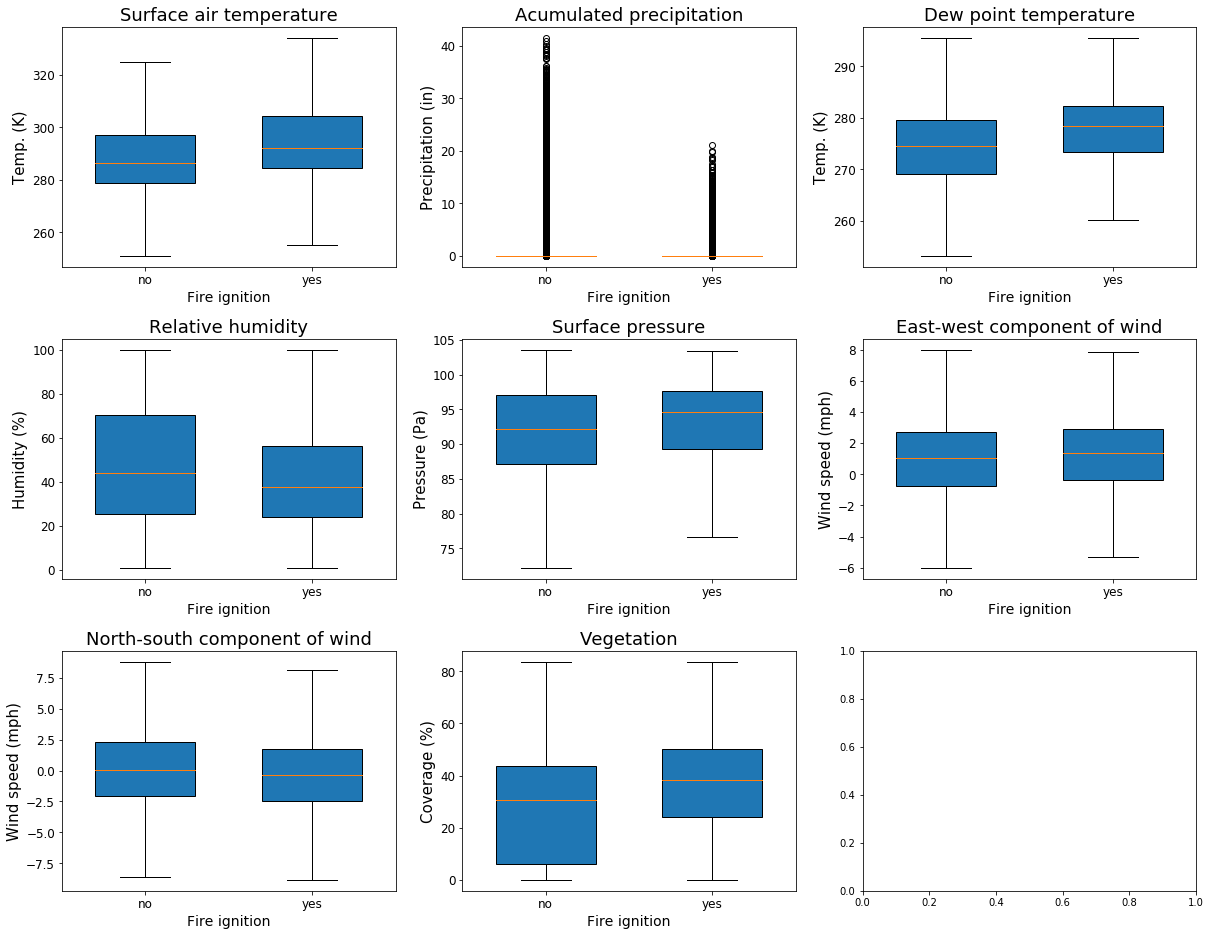

In [326]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig, ax = plt.subplots(3, 3, figsize=(30, 15))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

plot_data = [no_ignition['air.sfc'], ignition['air.sfc']]

ax[0,0].boxplot(plot_data, showfliers=False, widths = 0.6, patch_artist = True)
ax[0,0].tick_params(labelsize=12)
ax[0,0].set_title('Surface air temperature', fontsize=18)
ax[0,0].set_xlabel('Fire ignition', fontsize=14)
ax[0,0].set_ylabel('Temp. (K)', fontsize=15)
ax[0,0].set_xticklabels(['no','yes'])

plot_data = [no_ignition['apcp'], ignition['apcp']]

ax[0,1].boxplot(plot_data, widths = 0.6, patch_artist = True)
ax[0,1].tick_params(labelsize=12)
ax[0,1].set_title('Acumulated precipitation', fontsize=18)
ax[0,1].set_xlabel('Fire ignition', fontsize=14)
ax[0,1].set_ylabel('Precipitation (in)', fontsize=15)
ax[0,1].set_xticklabels(['no','yes'])

plot_data = [no_ignition['dpt.2m'], ignition['dpt.2m']]

ax[0,2].boxplot(plot_data, showfliers=False, widths = 0.6, patch_artist = True)
ax[0,2].tick_params(labelsize=12)
ax[0,2].set_title('Dew point temperature', fontsize=18)
ax[0,2].set_xlabel('Fire ignition', fontsize=14)
ax[0,2].set_ylabel('Temp. (K)', fontsize=15)
ax[0,2].set_xticklabels(['no','yes'])

plot_data = [no_ignition['rhum.2m'], ignition['rhum.2m']]

ax[1,0].boxplot(plot_data, showfliers=False, widths = 0.6, patch_artist = True)
ax[1,0].tick_params(labelsize=12)
ax[1,0].set_title('Relative humidity', fontsize=18)
ax[1,0].set_xlabel('Fire ignition', fontsize=14)
ax[1,0].set_ylabel('Humidity (%)', fontsize=15)
ax[1,0].set_xticklabels(['no','yes'])

plot_data = [no_ignition['pres.sfc'], ignition['pres.sfc']]

ax[1,1].boxplot(plot_data, showfliers=False, widths = 0.6, patch_artist = True)
ax[1,1].tick_params(labelsize=12)
ax[1,1].set_title('Surface pressure', fontsize=18)
ax[1,1].set_xlabel('Fire ignition', fontsize=14)
ax[1,1].set_ylabel('Pressure (Pa)', fontsize=15)
ax[1,1].set_xticklabels(['no','yes'])

plot_data = [no_ignition['uwnd.10m'], ignition['uwnd.10m']]

ax[1,2].boxplot(plot_data, showfliers=False, widths = 0.6, patch_artist = True)
ax[1,2].tick_params(labelsize=12)
ax[1,2].set_title('East-west component of wind', fontsize=18)
ax[1,2].set_xlabel('Fire ignition', fontsize=14)
ax[1,2].set_ylabel('Wind speed (mph)', fontsize=15)
ax[1,2].set_xticklabels(['no','yes'])

plot_data = [no_ignition['vwnd.10m'], ignition['vwnd.10m']]

ax[2,0].boxplot(plot_data, showfliers=False, widths = 0.6, patch_artist = True)
ax[2,0].tick_params(labelsize=12)
ax[2,0].set_title('North-south component of wind', fontsize=18)
ax[2,0].set_xlabel('Fire ignition', fontsize=14)
ax[2,0].set_ylabel('Wind speed (mph)', fontsize=15)
ax[2,0].set_xticklabels(['no','yes'])

plot_data = [no_ignition['veg'], ignition['veg']]

ax[2,1].boxplot(plot_data, showfliers=False, widths = 0.6, patch_artist = True)
ax[2,1].tick_params(labelsize=12)
ax[2,1].set_title('Vegetation', fontsize=18)
ax[2,1].set_xlabel('Fire ignition', fontsize=14)
ax[2,1].set_ylabel('Coverage (%)', fontsize=15)
ax[2,1].set_xticklabels(['no','yes'])
plt.show()

In [323]:
def calculate_frac_ignitions(data_type, num_bins):
    max_val = max(data[data_type])
    min_val = min(data[data_type])
    freq = (max_val - min_val) / num_bins
    bins = pd.interval_range(start=min_val, freq=freq, end=max_val)
    ignitions = pd.cut(ignition[data_type], bins=bins)
    all_data = pd.cut(data[data_type], bins=bins)
    fraction_ignitions = ignitions.value_counts() / all_data.value_counts()
    real_bin_nums = range(len(fraction_ignitions))
    return(fraction_ignitions, real_bin_nums)

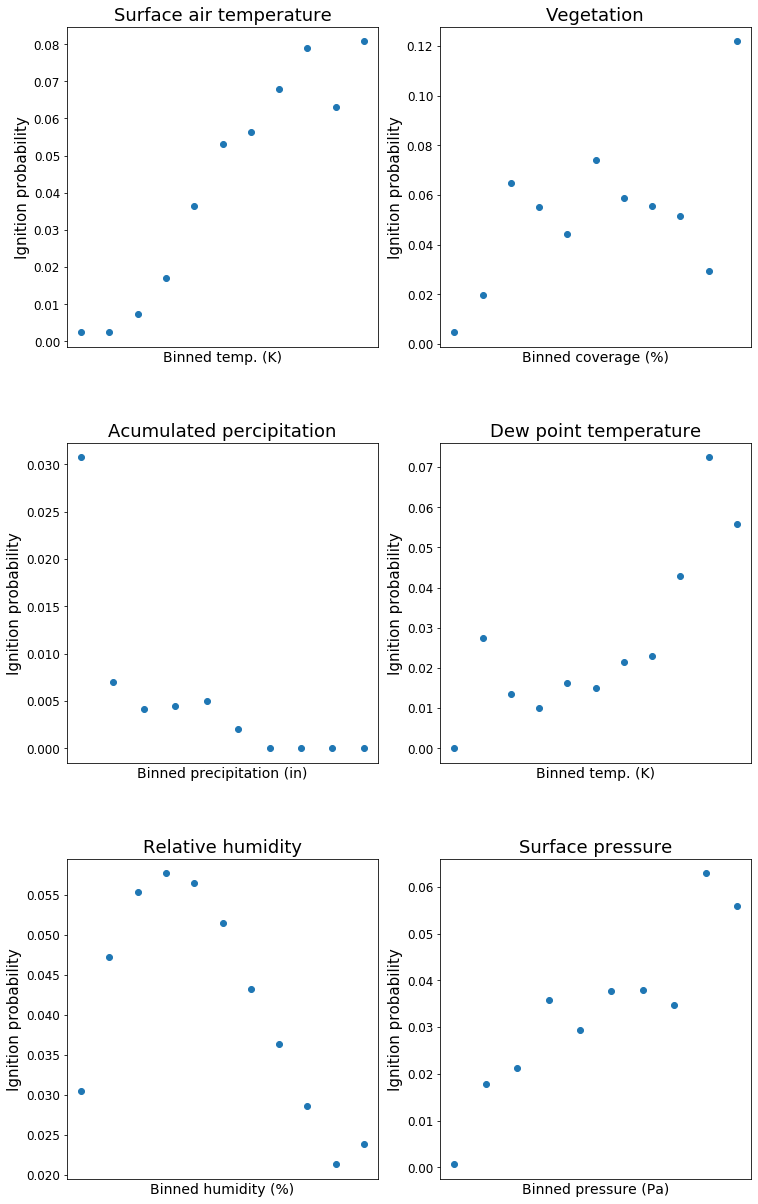

In [324]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.6    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

num_bins = 11
bin_nums = range(num_bins)

fig, ax = plt.subplots(3, 2, figsize=(20, 20))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

plot_data, real_bin_nums = calculate_frac_ignitions('air.sfc', num_bins)

ax[0,0].plot(real_bin_nums, plot_data, 'o')
ax[0,0].tick_params(labelsize=12)
ax[0,0].set_title('Surface air temperature', fontsize=18)
ax[0,0].set_xlabel('Binned temp. (K)', fontsize=14)
ax[0,0].set_ylabel('Ignition probability', fontsize=15)
ax[0,0].set_xticks([])

plot_data, real_bin_nums = calculate_frac_ignitions('veg', num_bins)

ax[0,1].plot(real_bin_nums, plot_data, 'o')
ax[0,1].tick_params(labelsize=12)
ax[0,1].set_title('Vegetation', fontsize=18)
ax[0,1].set_xlabel('Binned coverage (%)', fontsize=14)
ax[0,1].set_ylabel('Ignition probability', fontsize=15)
ax[0,1].set_xticks([])

plot_data, real_bin_nums = calculate_frac_ignitions('apcp', num_bins)

ax[1,0].plot(real_bin_nums, plot_data, 'o')
ax[1,0].tick_params(labelsize=12)
ax[1,0].set_title('Acumulated percipitation', fontsize=18)
ax[1,0].set_xlabel('Binned precipitation (in)', fontsize=14)
ax[1,0].set_ylabel('Ignition probability', fontsize=15)
ax[1,0].set_xticks([])

plot_data, real_bin_nums = calculate_frac_ignitions('dpt.2m', num_bins)

ax[1,1].plot(real_bin_nums, plot_data, 'o')
ax[1,1].tick_params(labelsize=12)
ax[1,1].set_title('Dew point temperature', fontsize=18)
ax[1,1].set_xlabel('Binned temp. (K)', fontsize=14)
ax[1,1].set_ylabel('Ignition probability', fontsize=15)
ax[1,1].set_xticks([])

plot_data, real_bin_nums = calculate_frac_ignitions('rhum.2m', num_bins)

ax[2,0].plot(real_bin_nums, plot_data, 'o')
ax[2,0].tick_params(labelsize=12)
ax[2,0].set_title('Relative humidity', fontsize=18)
ax[2,0].set_xlabel('Binned humidity (%)', fontsize=14)
ax[2,0].set_ylabel('Ignition probability', fontsize=15)
ax[2,0].set_xticks([])

plot_data, real_bin_nums = calculate_frac_ignitions('pres.sfc', num_bins)

ax[2,1].plot(real_bin_nums, plot_data, 'o')
ax[2,1].tick_params(labelsize=12)
ax[2,1].set_title('Surface pressure', fontsize=18)
ax[2,1].set_xlabel('Binned pressure (Pa)', fontsize=14)
ax[2,1].set_ylabel('Ignition probability', fontsize=15)
ax[2,1].set_xticks([])

plt.show()